<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/CatBoast(_3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
!pip install catboost

In [126]:
# CatBoost Agricultural Production Classification - Step by Step Guide
# Run each step one by one for better understanding

# =============================================================================
# STEP 1: INSTALL AND IMPORT REQUIRED LIBRARIES
# =============================================================================
# First, install required packages (run in terminal/command prompt):
# pip install catboost pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


In [127]:

# =============================================================================
# STEP 2: LOAD THE DATA
# =============================================================================
print("\n" + "="*50)
print("STEP 2: LOADING DATA")
print("="*50)

# Load the three CSV files
try:
    train_df = pd.read_csv("//content/drive/MyDrive/UpdatedDataset/train.csv")
    val_df = pd.read_csv("/content/drive/MyDrive/UpdatedDataset/validation.csv")
    test_df = pd.read_csv("/content/drive/MyDrive/UpdatedDataset/test.csv")

    print(f"✓ Training data loaded: {train_df.shape}")
    print(f"✓ Validation data loaded: {val_df.shape}")
    print(f"✓ Test data loaded: {test_df.shape}")

    # Display basic info about the data
    print(f"\nFirst few columns: {list(train_df.columns[:5])}")
    print(f"Target column: Production (M.Ton)")
    print(f"Production range in training: {train_df['Production (M.Ton)'].min():.2f} - {train_df['Production (M.Ton)'].max():.2f}")

except FileNotFoundError as e:
    print("❌ Error: CSV files not found!")
    print("Please make sure you have train.csv, validation.csv, and test.csv in your working directory")
    print("Stopping execution...")
    exit()


STEP 2: LOADING DATA
✓ Training data loaded: (3942, 84)
✓ Validation data loaded: (845, 84)
✓ Test data loaded: (845, 84)

First few columns: ['Production (M.Ton)', 'Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)']
Target column: Production (M.Ton)
Production range in training: 0.00 - 544979.50


In [128]:
# =============================================================================
# STEP 3: EXPLORE THE DATA
# =============================================================================
print("\n" + "="*50)
print("STEP 3: DATA EXPLORATION")
print("="*50)

# Check for missing values
print("Missing values in training data:")
missing_values = train_df.isnull().sum()
print(f"Total missing values: {missing_values.sum()}")


STEP 3: DATA EXPLORATION
Missing values in training data:
Total missing values: 0


In [129]:

# =============================================================================
# STEP 4: CREATE QUANTILE-BASED LABELS
# =============================================================================
print("\n" + "="*50)
print("STEP 4: CREATING PRODUCTION LABELS")
print("="*50)

# Calculate quantiles from training data only
production_values = train_df['Production (M.Ton)']
low_threshold = production_values.quantile(0.33)
high_threshold = production_values.quantile(0.67)

print(f"Quantile thresholds:")
print(f"Low threshold (33rd percentile): {low_threshold:.2f}")
print(f"High threshold (67th percentile): {high_threshold:.2f}")

# Function to create labels
def create_production_labels(df, low_thresh, high_thresh):
    """Create production category labels"""
    return pd.cut(
        df['Production (M.Ton)'],
        bins=[-np.inf, low_thresh, high_thresh, np.inf],
        labels=['low', 'medium', 'high']
    )

# Apply labeling to all datasets
train_df['production_category'] = create_production_labels(train_df, low_threshold, high_threshold)
val_df['production_category'] = create_production_labels(val_df, low_threshold, high_threshold)
test_df['production_category'] = create_production_labels(test_df, low_threshold, high_threshold)

# Print distribution for each dataset
for df, name in [(train_df, 'Training'), (val_df, 'Validation'), (test_df, 'Test')]:
    print(f"\n{name} set production distribution:")
    print(df['production_category'].value_counts())
    print(f"Percentages: {(df['production_category'].value_counts(normalize=True) * 100).round(2)}")



STEP 4: CREATING PRODUCTION LABELS
Quantile thresholds:
Low threshold (33rd percentile): 1071.56
High threshold (67th percentile): 4035.91

Training set production distribution:
production_category
medium    1340
low       1301
high      1301
Name: count, dtype: int64
Percentages: production_category
medium    33.99
low       33.00
high      33.00
Name: proportion, dtype: float64

Validation set production distribution:
production_category
medium    297
low       278
high      270
Name: count, dtype: int64
Percentages: production_category
medium    35.15
low       32.90
high      31.95
Name: proportion, dtype: float64

Test set production distribution:
production_category
high      291
medium    280
low       274
Name: count, dtype: int64
Percentages: production_category
high      34.44
medium    33.14
low       32.43
Name: proportion, dtype: float64


In [130]:

# =============================================================================
# STEP 5: PREPARE FEATURES AND LABELS
# =============================================================================
print("\n" + "="*50)
print("STEP 5: PREPARING FEATURES AND LABELS")
print("="*50)

# Identify feature columns (exclude target and created category)
feature_columns = [col for col in train_df.columns
                  if col not in ['Production (M.Ton)', 'production_category']]

print(f"Total number of features: {len(feature_columns)}")
print(f"Sample features: {feature_columns[:5]}")

# Prepare features
X_train = train_df[feature_columns]
X_val = val_df[feature_columns]
X_test = test_df[feature_columns]

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['production_category'])
y_val = label_encoder.transform(val_df['production_category'])
y_test = label_encoder.transform(test_df['production_category'])

print(f"Label encoding: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")



STEP 5: PREPARING FEATURES AND LABELS
Total number of features: 83
Sample features: ['Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)']
Label encoding: {'high': 0, 'low': 1, 'medium': 2}
Training labels shape: (3942,)
Validation labels shape: (845,)
Test labels shape: (845,)


In [131]:

# =============================================================================
# STEP 6: INITIALIZE AND TRAIN CATBOOST MODEL
# =============================================================================
print("\n" + "="*50)
print("STEP 6: TRAINING CATBOOST MODEL")
print("="*50)

# Initialize CatBoost classifier
model = CatBoostClassifier(
    iterations=1000,           # Number of epochs
    learning_rate=0.1,         # Learning rate
    depth=6,                   # Tree depth
    eval_metric='MultiClass',  # Evaluation metric
    random_seed=42,            # For reproducibility
    verbose=100,               # Print progress every 100 iterations
    early_stopping_rounds=50,  # Stop if no improvement for 50 rounds
    use_best_model=True        # Use the best model from training
)

print("Starting model training...")
print("This may take a few minutes depending on your data size...")

# Train model with validation data for early stopping
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    plot=False,
    verbose_eval=100
)

print(f"\n✓ Model training completed!")
print(f"Best iteration: {model.get_best_iteration()}")
print(f"Best score: {model.get_best_score()}")



STEP 6: TRAINING CATBOOST MODEL
Starting model training...
This may take a few minutes depending on your data size...
0:	learn: 0.9988791	test: 0.9988571	best: 0.9988571 (0)	total: 10.6ms	remaining: 10.6s
100:	learn: 0.2667291	test: 0.2988258	best: 0.2988258 (100)	total: 976ms	remaining: 8.69s
200:	learn: 0.2012634	test: 0.2501461	best: 0.2501461 (200)	total: 2.17s	remaining: 8.63s
300:	learn: 0.1664970	test: 0.2310806	best: 0.2310806 (300)	total: 3.3s	remaining: 7.66s
400:	learn: 0.1404973	test: 0.2200256	best: 0.2200256 (400)	total: 6.54s	remaining: 9.77s
500:	learn: 0.1216905	test: 0.2125299	best: 0.2125299 (500)	total: 9.11s	remaining: 9.07s
600:	learn: 0.1073737	test: 0.2071919	best: 0.2071800 (598)	total: 11.6s	remaining: 7.69s
700:	learn: 0.0951789	test: 0.2037525	best: 0.2037174 (696)	total: 13.9s	remaining: 5.91s
800:	learn: 0.0852474	test: 0.2015682	best: 0.2015682 (800)	total: 15.8s	remaining: 3.92s
900:	learn: 0.0766666	test: 0.1996437	best: 0.1995827 (886)	total: 17.8s	re


STEP 7: PLOTTING TRAINING HISTORY


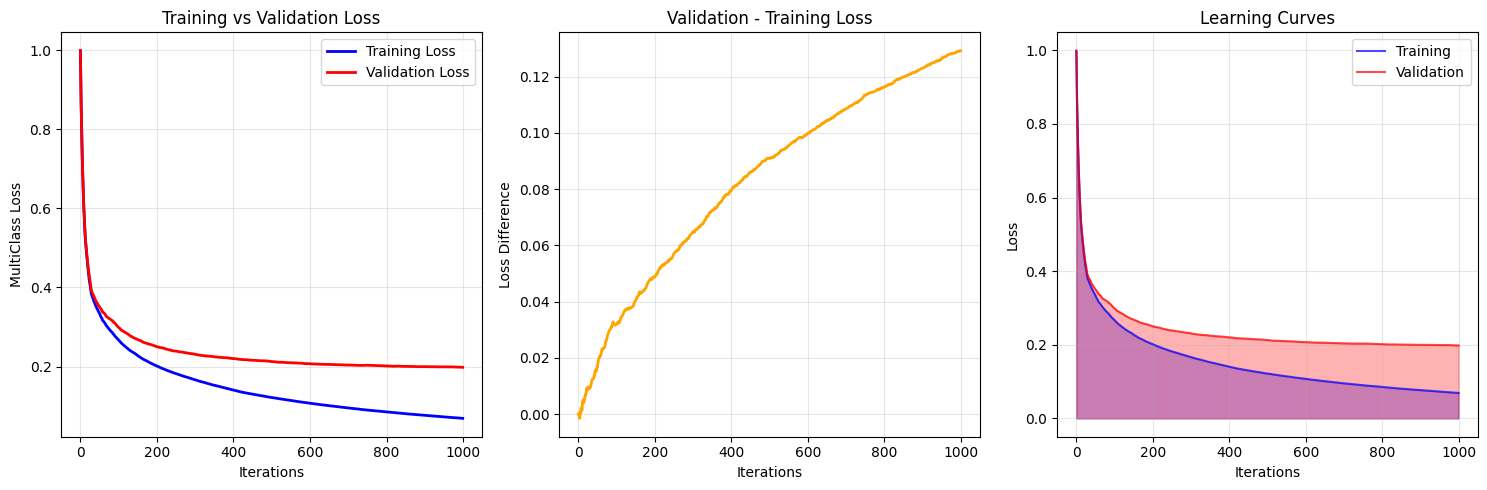

In [132]:
# =============================================================================
# STEP 7: PLOT TRAINING HISTORY
# =============================================================================
print("\n" + "="*50)
print("STEP 7: PLOTTING TRAINING HISTORY")
print("="*50)

# Get training history
evals_result = model.get_evals_result()

if 'validation' in evals_result:
    train_scores = evals_result['learn']['MultiClass']
    val_scores = evals_result['validation']['MultiClass']

    plt.figure(figsize=(15, 5))

    # Plot 1: Training vs Validation Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_scores, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_scores, label='Validation Loss', color='red', linewidth=2)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('MultiClass Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Loss difference
    plt.subplot(1, 3, 2)
    loss_diff = np.array(val_scores) - np.array(train_scores)
    plt.plot(loss_diff, color='orange', linewidth=2)
    plt.title('Validation - Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss Difference')
    plt.grid(True, alpha=0.3)

    # Plot 3: Learning curve
    plt.subplot(1, 3, 3)
    plt.plot(range(len(train_scores)), train_scores, 'b-', alpha=0.7, label='Training')
    plt.plot(range(len(val_scores)), val_scores, 'r-', alpha=0.7, label='Validation')
    plt.fill_between(range(len(train_scores)), train_scores, alpha=0.3, color='blue')
    plt.fill_between(range(len(val_scores)), val_scores, alpha=0.3, color='red')
    plt.title('Learning Curves')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No validation scores available for plotting.")


In [133]:
# =============================================================================
# STEP 8: EVALUATE MODEL ON VALIDATION SET
# =============================================================================
print("\n" + "="*50)
print("STEP 8: VALIDATION SET EVALUATION")
print("="*50)

# Make predictions on validation set
y_val_pred = model.predict(X_val)
y_val_pred_proba = model.predict_proba(X_val)

# Calculate all metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision_macro = precision_score(y_val, y_val_pred, average='macro')
val_recall_macro = recall_score(y_val, y_val_pred, average='macro')
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')

# Print validation results
print("VALIDATION SET METRICS:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision (Macro): {val_precision_macro:.4f}")
print(f"Recall (Macro): {val_recall_macro:.4f}")
print(f"F1-Score (Macro): {val_f1_macro:.4f}")
print(f"F1-Score (Weighted): {val_f1_weighted:.4f}")

# Per-class metrics
val_precision_per_class = precision_score(y_val, y_val_pred, average=None)
val_recall_per_class = recall_score(y_val, y_val_pred, average=None)
val_f1_per_class = f1_score(y_val, y_val_pred, average=None)

print(f"\nPER-CLASS METRICS (Validation):")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: Precision={val_precision_per_class[i]:.4f}, "
          f"Recall={val_recall_per_class[i]:.4f}, F1={val_f1_per_class[i]:.4f}")

# Detailed classification report
print(f"\nDETAILED CLASSIFICATION REPORT (Validation):")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))



STEP 8: VALIDATION SET EVALUATION
VALIDATION SET METRICS:
Accuracy: 0.9243
Precision (Macro): 0.9268
Recall (Macro): 0.9243
F1-Score (Macro): 0.9253
F1-Score (Weighted): 0.9246

PER-CLASS METRICS (Validation):
high: Precision=0.9423, Recall=0.9074, F1=0.9245
low: Precision=0.9635, Recall=0.9496, F1=0.9565
medium: Precision=0.8746, Recall=0.9158, F1=0.8947

DETAILED CLASSIFICATION REPORT (Validation):
              precision    recall  f1-score   support

        high       0.94      0.91      0.92       270
         low       0.96      0.95      0.96       278
      medium       0.87      0.92      0.89       297

    accuracy                           0.92       845
   macro avg       0.93      0.92      0.93       845
weighted avg       0.93      0.92      0.92       845



In [134]:
# =============================================================================
# STEP 9: EVALUATE MODEL ON TEST SET
# =============================================================================
print("\n" + "="*50)
print("STEP 9: TEST SET EVALUATION")
print("="*50)

# Make predictions on test set
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)

# Calculate all metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

# Print test results
print("TEST SET METRICS:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision (Macro): {test_precision_macro:.4f}")
print(f"Recall (Macro): {test_recall_macro:.4f}")
print(f"F1-Score (Macro): {test_f1_macro:.4f}")
print(f"F1-Score (Weighted): {test_f1_weighted:.4f}")

# Per-class metrics
test_precision_per_class = precision_score(y_test, y_test_pred, average=None)
test_recall_per_class = recall_score(y_test, y_test_pred, average=None)
test_f1_per_class = f1_score(y_test, y_test_pred, average=None)

print(f"\nPER-CLASS METRICS (Test):")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: Precision={test_precision_per_class[i]:.4f}, "
          f"Recall={test_recall_per_class[i]:.4f}, F1={test_f1_per_class[i]:.4f}")

# Detailed classification report
print(f"\nDETAILED CLASSIFICATION REPORT (Test):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))



STEP 9: TEST SET EVALUATION
TEST SET METRICS:
Accuracy: 0.9361
Precision (Macro): 0.9374
Recall (Macro): 0.9363
F1-Score (Macro): 0.9366
F1-Score (Weighted): 0.9365

PER-CLASS METRICS (Test):
high: Precision=0.9541, Recall=0.9278, F1=0.9408
low: Precision=0.9739, Recall=0.9526, F1=0.9631
medium: Precision=0.8844, Recall=0.9286, F1=0.9059

DETAILED CLASSIFICATION REPORT (Test):
              precision    recall  f1-score   support

        high       0.95      0.93      0.94       291
         low       0.97      0.95      0.96       274
      medium       0.88      0.93      0.91       280

    accuracy                           0.94       845
   macro avg       0.94      0.94      0.94       845
weighted avg       0.94      0.94      0.94       845




STEP 10: PLOTTING CONFUSION MATRICES


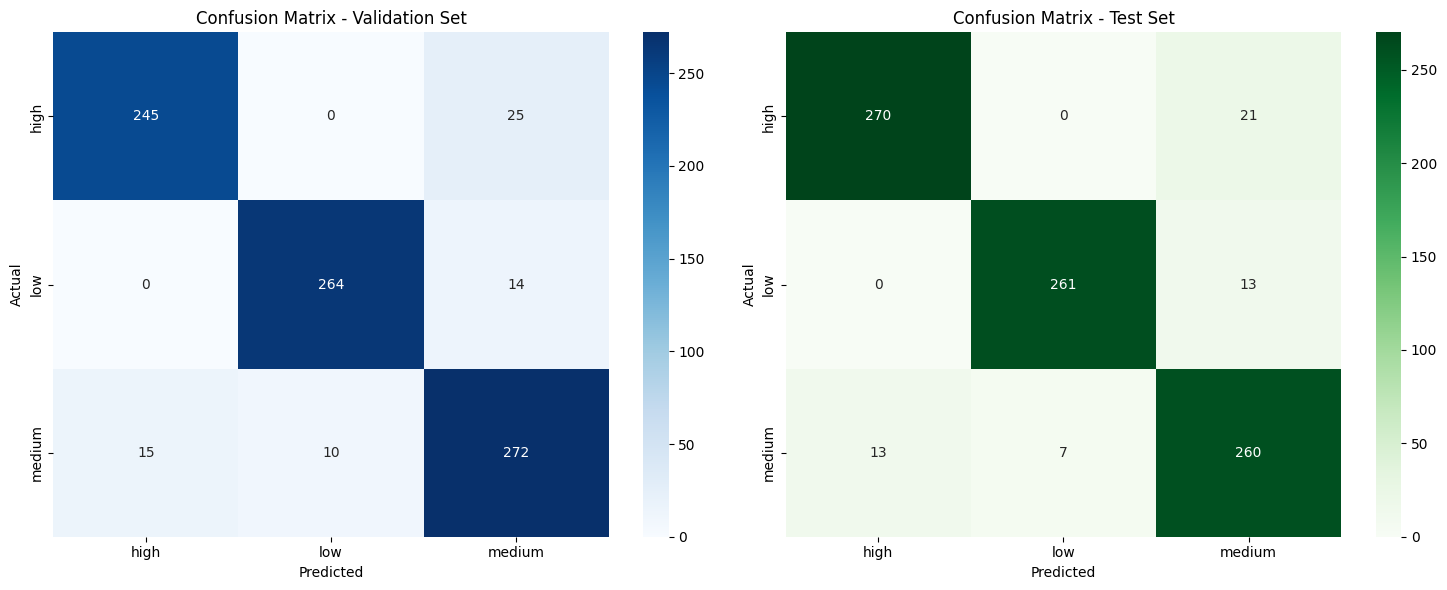

In [135]:
# =============================================================================
# STEP 10: PLOT CONFUSION MATRICES
# =============================================================================
print("\n" + "="*50)
print("STEP 10: PLOTTING CONFUSION MATRICES")
print("="*50)

# Create confusion matrices
val_cm = confusion_matrix(y_val, y_val_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(15, 6))

# Validation confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Test confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


STEP 11: PLOTTING ACCURACY COMPARISON


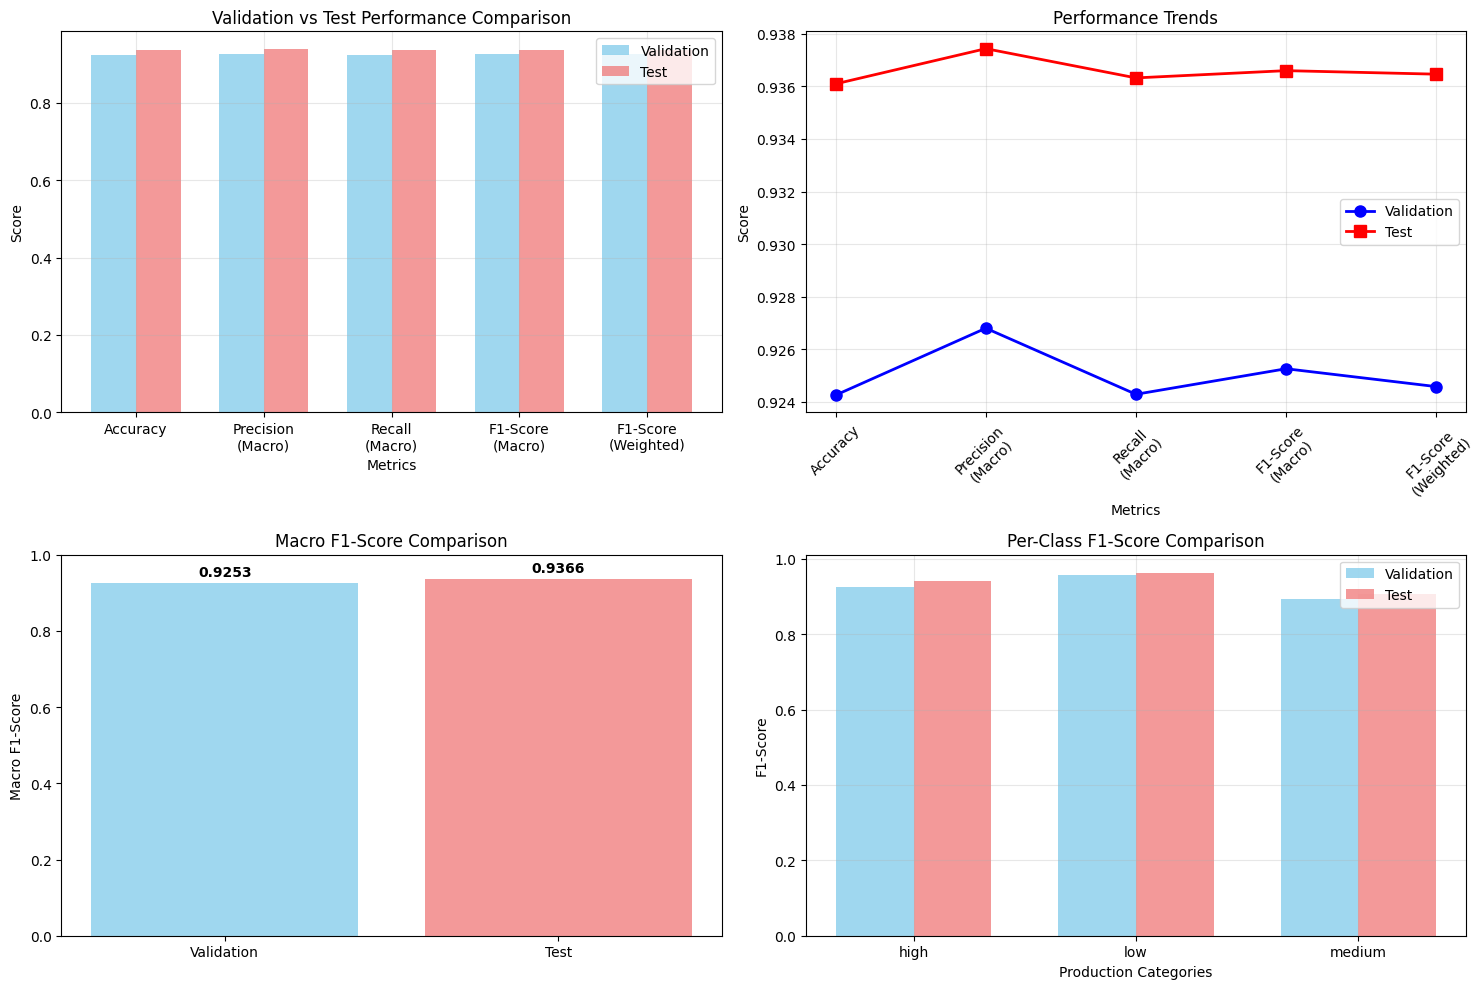

In [136]:
# =============================================================================
# STEP 11: PLOT ACCURACY COMPARISON
# =============================================================================
print("\n" + "="*50)
print("STEP 11: PLOTTING ACCURACY COMPARISON")
print("="*50)

# Create comparison data
metrics_names = ['Accuracy', 'Precision\n(Macro)', 'Recall\n(Macro)', 'F1-Score\n(Macro)', 'F1-Score\n(Weighted)']
validation_scores = [val_accuracy, val_precision_macro, val_recall_macro, val_f1_macro, val_f1_weighted]
test_scores = [test_accuracy, test_precision_macro, test_recall_macro, test_f1_macro, test_f1_weighted]

# Create comparison plots
plt.figure(figsize=(15, 10))

# Bar plot comparison
plt.subplot(2, 2, 1)
x = np.arange(len(metrics_names))
width = 0.35
plt.bar(x - width/2, validation_scores, width, label='Validation', color='skyblue', alpha=0.8)
plt.bar(x + width/2, test_scores, width, label='Test', color='lightcoral', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Validation vs Test Performance Comparison')
plt.xticks(x, metrics_names)
plt.legend()
plt.grid(True, alpha=0.3)

# Line plot comparison
plt.subplot(2, 2, 2)
plt.plot(metrics_names, validation_scores, 'o-', linewidth=2, markersize=8, label='Validation', color='blue')
plt.plot(metrics_names, test_scores, 's-', linewidth=2, markersize=8, label='Test', color='red')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Trends')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Macro F1 Score focus
plt.subplot(2, 2, 3)
categories = ['Validation', 'Test']
macro_f1_scores = [val_f1_macro, test_f1_macro]
colors = ['skyblue', 'lightcoral']
bars = plt.bar(categories, macro_f1_scores, color=colors, alpha=0.8)
plt.ylabel('Macro F1-Score')
plt.title('Macro F1-Score Comparison')
plt.ylim(0, 1)
# Add value labels on bars
for bar, score in zip(bars, macro_f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# Per-class F1 scores comparison
plt.subplot(2, 2, 4)
x = np.arange(len(label_encoder.classes_))
width = 0.35
plt.bar(x - width/2, val_f1_per_class, width, label='Validation', color='skyblue', alpha=0.8)
plt.bar(x + width/2, test_f1_per_class, width, label='Test', color='lightcoral', alpha=0.8)
plt.xlabel('Production Categories')
plt.ylabel('F1-Score')
plt.title('Per-Class F1-Score Comparison')
plt.xticks(x, label_encoder.classes_)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [137]:



# =============================================================================
# STEP 12: FEATURE IMPORTANCE ANALYSIS
# =============================================================================
print("\n" + "="*50)
print("STEP 12: FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get feature importance
feature_importance = model.get_feature_importance()
feature_names = feature_columns

# Create DataFrame for easier handling
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))




STEP 12: FEATURE IMPORTANCE ANALYSIS
Top 20 Most Important Features:
                                         feature  importance
                                    Area (Acres)   43.351397
                                    Crop_Cabbage    5.071016
                                            Year    4.745934
                                      Crop_Beans    4.095040
                                     Crop_Garlic    3.628992
                                     Crop_Tomato    3.336218
               Temperature at 2 Meters Range (C)    3.307904
                                    Crop_Laushak    3.284035
                    soil_temperature_0_to_7cm(C)    3.195746
                                     Crop_Radish    2.905065
                 soil_moisture_0_to_7cm(mÂ³/mÂ³)    2.575939
                                Crop_Cauliflower    2.535435
                         relative_humidity_2m(%)    2.188326
                                   total_rain_mm    2.066797
               

In [138]:

# =============================================================================
# STEP 13: FINAL SUMMARY AND RESULTS
# =============================================================================
print("\n" + "="*60)
print("STEP 13: FINAL SUMMARY AND RESULTS")
print("="*60)

print("QUANTILE THRESHOLDS:")
print(f"Low production threshold: {low_threshold:.2f} M.Ton")
print(f"High production threshold: {high_threshold:.2f} M.Ton")

print(f"\nMODEL TRAINING SUMMARY:")
print(f"Total features used: {len(feature_columns)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Best iteration: {model.get_best_iteration()}")

print(f"\nVALIDATION SET PERFORMANCE:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Macro F1-Score: {val_f1_macro:.4f}")
print(f"Weighted F1-Score: {val_f1_weighted:.4f}")

print(f"\nTEST SET PERFORMANCE:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Macro F1-Score: {test_f1_macro:.4f}")
print(f"Weighted F1-Score: {test_f1_weighted:.4f}")

print(f"\nTOP 5 MOST IMPORTANT FEATURES:")
for i, row in importance_df.head(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.2f}")

print(f"\n{'='*60}")
print("CLASSIFICATION MODEL COMPLETED SUCCESSFULLY!")
print("="*60)



STEP 13: FINAL SUMMARY AND RESULTS
QUANTILE THRESHOLDS:
Low production threshold: 1071.56 M.Ton
High production threshold: 4035.91 M.Ton

MODEL TRAINING SUMMARY:
Total features used: 83
Training samples: 3942
Validation samples: 845
Test samples: 845
Best iteration: 999

VALIDATION SET PERFORMANCE:
Accuracy: 0.9243
Macro F1-Score: 0.9253
Weighted F1-Score: 0.9246

TEST SET PERFORMANCE:
Accuracy: 0.9361
Macro F1-Score: 0.9366
Weighted F1-Score: 0.9365

TOP 5 MOST IMPORTANT FEATURES:
Area (Acres): 43.35
Crop_Cabbage: 5.07
Year: 4.75
Crop_Beans: 4.10
Crop_Garlic: 3.63

CLASSIFICATION MODEL COMPLETED SUCCESSFULLY!


In [139]:

# =============================================================================
# STEP 14: SAMPLE PREDICTIONS (BONUS)
# =============================================================================
print("\n" + "="*50)
print("STEP 14: SAMPLE PREDICTIONS")
print("="*50)

# Show some sample predictions
sample_size = min(10, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)

print("Sample Predictions vs Actual Values:")
print("-" * 80)
print("Index  Actual   Predicted  Confidence   Correct")
print("-" * 80)

for i, idx in enumerate(sample_indices):
    # Get the actual values safely
    idx_val = int(idx)
    actual_class_idx = int(y_test[idx])
    pred_class_idx = int(y_test_pred[idx])

    # Get class names
    actual_label = label_encoder.classes_[actual_class_idx]
    pred_label = label_encoder.classes_[pred_class_idx]

    # Get confidence (convert numpy array to float)
    confidence_val = y_test_pred_proba[idx]
    max_confidence = float(np.max(confidence_val))

    # Check if correct
    is_correct = "✓" if actual_label == pred_label else "✗"

    # Print using .format() instead of f-strings to avoid numpy issues
    print("{:<6} {:<8} {:<10} {:.3f}       {}".format(
        idx_val, actual_label, pred_label, max_confidence, is_correct
    ))

print("\n" + "="*60)
print("ALL STEPS COMPLETED! Your CatBoost model is ready for use.")
print("="*60)


STEP 14: SAMPLE PREDICTIONS
Sample Predictions vs Actual Values:
--------------------------------------------------------------------------------
Index  Actual   Predicted  Confidence   Correct
--------------------------------------------------------------------------------
60     medium   low        0.663       ✗
391    low      low        0.992       ✓
384    low      low        0.999       ✓
320    medium   medium     0.793       ✓
587    high     medium     0.568       ✗
683    high     high       0.996       ✓
506    medium   medium     0.991       ✓
327    low      low        1.000       ✓
717    medium   medium     0.932       ✓
8      low      low        0.999       ✓

ALL STEPS COMPLETED! Your CatBoost model is ready for use.
